In [25]:
# import packages
import pandas as pd
import os
import csv
import numpy as np
import gensim
import gensim.corpora as corpora
from gensim.models import ldaseqmodel
import time
from collections import Counter
import pyLDAvis
import pyLDAvis.gensim  
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [2]:
# read in csv file
all_data = pd.read_csv('./all_data.csv', header=None)
# add columns
all_data.columns = ["year", "title", "article"]
# sort by year
all_data = all_data.sort_values(by=['year'])
# change index
new_index = np.arange(0, len(all_data))
all_data["new_index"] = new_index
all_data = all_data.set_index('new_index')

In [9]:
# split for lda
data_50s = all_data[all_data["year"] < 1960]
data_70s = all_data[(all_data["year"] < 1979) & (all_data["year"] > 1970)]
data_80s = all_data[(all_data["year"] < 1990) & (all_data["year"] > 1979)]
data_90s = all_data[all_data["year"] > 1989]
data_before_1979 = all_data[all_data["year"] < 1979]

In [10]:
# construct the stop word list
stopwords = [line.strip() for line in open("stop_words_copy.txt",encoding='UTF-8').readlines()]

In [11]:
# construct the function that preprocess the text
def preprocess(text):
    '''
    Preprocess the text by tokenizing the string into uni-grams, deleting all 
    numbers, punctuations and stop words. Store the preprocessed sting into 
    a list of words
    
    input: 
        text: text for preprocessing(str)
    output: a list of words
    '''
    result = []
    tokens = gensim.utils.tokenize(text)
    tokens_lst = list(tokens)
    for token in tokens_lst:
        if token not in stopwords:
            result.append(token)
            
    return result

In [12]:
# preprocess the data
processed_50s = data_50s['article'].map(preprocess)
processed_70s = data_70s['article'].map(preprocess)
processed_80s = data_80s['article'].map(preprocess)
processed_90s = data_90s['article'].map(preprocess)
processed_before_1979 = data_before_1979['article'].map(preprocess)

In [14]:
# prepare Document-Term Matrix for the DTA model 
# Create Dictionaries for unique word counts of each decade
dic_50s = corpora.Dictionary(processed_50s)
dic_70s = corpora.Dictionary(processed_70s)
dic_80s = corpora.Dictionary(processed_80s)
dic_90s = corpora.Dictionary(processed_90s)
dic_before_1979 = corpora.Dictionary(processed_before_1979)

# Create Corpus: Term Document Frequency
corpus_50s = [dic_50s.doc2bow(text) for text in processed_50s]
corpus_70s = [dic_70s.doc2bow(text) for text in processed_70s]
corpus_80s = [dic_80s.doc2bow(text) for text in processed_80s]
corpus_90s = [dic_90s.doc2bow(text) for text in processed_90s]
corpus_before_1979 = [dic_before_1979.doc2bow(text) for text in processed_before_1979]

In [15]:
# Construct the function that builds the lda model with 10 topics
def lda_model(corpus, dictionary):
    '''
    Build a lda model with 10 topics using the corpus and dictionary
    imput:
        corpus: the Term Document Frequency corpus used to build the mode
        dictionary: a dictionary containing word counts of each unique word
                    in the dataframe for each decade
    output: a lda model object
    '''
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=400,
                                           per_word_topics=True)
    return lda_model

In [17]:
# build the LDA models for the four corpus
lda_model_50 = lda_model(corpus_50s, dic_50s)

In [19]:
lda_model_70 = lda_model(corpus_70s, dic_70s)

In [21]:
lda_model_80 = lda_model(corpus_80s, dic_80s)

In [22]:
lda_model_90 = lda_model(corpus_90s, dic_90s)

In [20]:
lda_model_before_1979 = lda_model(corpus_before_1979, dic_before_1979)

In [41]:
print(lda_model_50.print_topics())

[(0, '0.030*"人口" + 0.027*"我国" + 0.017*"问题" + 0.012*"发展" + 0.012*"社会主义" + 0.010*"建设" + 0.010*"生产" + 0.009*"人民" + 0.008*"农业" + 0.008*"解决"'), (1, '0.017*"手术" + 0.009*"精管" + 0.007*"输" + 0.005*"结扎" + 0.004*"切断" + 0.004*"输精管" + 0.004*"精子" + 0.004*"怀孕" + 0.004*"例" + 0.003*"男子"'), (2, '0.011*"人工流产" + 0.011*"妇女" + 0.010*"工作" + 0.008*"避孕" + 0.008*"生育" + 0.008*"方法" + 0.007*"宣传" + 0.007*"人民" + 0.006*"子女" + 0.006*"结婚"'), (3, '0.012*"生产" + 0.011*"粮食" + 0.010*"斤" + 0.009*"农业社" + 0.006*"政府" + 0.006*"农书" + 0.006*"沁县" + 0.005*"创造" + 0.005*"地方" + 0.004*"娃娃"'), (4, '0.019*"人" + 0.011*"工业" + 0.011*"避孕" + 0.010*"农民" + 0.010*"工作" + 0.010*"生育" + 0.009*"人口" + 0.009*"生活" + 0.009*"增加" + 0.007*"积累"')]


In [56]:
topics_50 = lda_model_50.show_topics(num_words=20, formatted=False)
topics_50

[(0,
  [('人口', 0.029983375),
   ('我国', 0.027381515),
   ('问题', 0.017086199),
   ('发展', 0.012244429),
   ('社会主义', 0.012056679),
   ('建设', 0.010362741),
   ('生产', 0.010130028),
   ('人民', 0.009022748),
   ('农业', 0.008496851),
   ('解决', 0.0084353695),
   ('人', 0.008381596),
   ('新', 0.0083572),
   ('劳动力', 0.0075627426),
   ('矛盾', 0.007227686),
   ('劳动', 0.0071650334),
   ('中国', 0.0069509107),
   ('社会', 0.0069457195),
   ('技术', 0.0063755503),
   ('企业', 0.0050276415),
   ('提高', 0.004953002)]),
 (1,
  [('手术', 0.016848965),
   ('精管', 0.00853962),
   ('输', 0.007411397),
   ('结扎', 0.004595569),
   ('切断', 0.0044636233),
   ('输精管', 0.0040767626),
   ('精子', 0.003950033),
   ('怀孕', 0.0036933967),
   ('例', 0.0035310853),
   ('男子', 0.0034959528),
   ('施行', 0.0034774814),
   ('吻合', 0.0033120895),
   ('断术', 0.0033120895),
   ('输卵管', 0.003282606),
   ('子宫', 0.003272223),
   ('结扎切', 0.0029931176),
   ('方法', 0.0026826807),
   ('精液', 0.0026741459),
   ('正常', 0.0026685924),
   ('手段', 0.002546889)]),
 (2,
  [

In [50]:
print(lda_model_70.print_topics())

[(0, '0.027*"南宫县" + 0.009*"劳力" + 0.007*"亩" + 0.006*"著作" + 0.006*"宣" + 0.005*"增强" + 0.005*"投入" + 0.004*"文章" + 0.004*"毛泽东思想" + 0.004*"挖"'), (1, '0.048*"人口" + 0.015*"国家" + 0.015*"问题" + 0.013*"人民" + 0.013*"世界" + 0.012*"经济" + 0.012*"会议" + 0.009*"增长" + 0.009*"发展" + 0.007*"超级大国"'), (2, '0.042*"计划生育" + 0.034*"工作" + 0.011*"人口" + 0.010*"主席" + 0.008*"群众" + 0.008*"计划" + 0.007*"革命" + 0.007*"妇女" + 0.007*"晚婚" + 0.006*"领导"'), (3, '0.010*"花" + 0.007*"社论" + 0.007*"墨西哥" + 0.004*"东方红" + 0.004*"洛阳" + 0.004*"拖拉机" + 0.003*"限制" + 0.003*"女孩" + 0.003*"爱人" + 0.002*"再生"'), (4, '0.022*"规律" + 0.012*"贯彻" + 0.009*"讨论会" + 0.007*"中央" + 0.006*"领袖" + 0.006*"影片" + 0.005*"晚恋" + 0.005*"导师" + 0.005*"恋爱" + 0.005*"话"')]


In [57]:
topics_70 = lda_model_70.show_topics(num_words=20, formatted=False)
topics_70

[(0,
  [('南宫县', 0.026625857),
   ('劳力', 0.008982818),
   ('亩', 0.006524793),
   ('著作', 0.0064261947),
   ('宣', 0.006086845),
   ('增强', 0.0048014196),
   ('投入', 0.004577722),
   ('文章', 0.004345359),
   ('毛泽东思想', 0.0037854416),
   ('挖', 0.0036452056),
   ('土地', 0.0036449686),
   ('排除', 0.0035570466),
   ('蔡智荣', 0.0031561216),
   ('掖县', 0.0031561216),
   ('渠', 0.0030461876),
   ('做出', 0.0030461876),
   ('打井', 0.0030461876),
   ('基本建设', 0.0030461876),
   ('平整', 0.003046052),
   ('培训', 0.003045806)]),
 (1,
  [('人口', 0.048442792),
   ('国家', 0.015451085),
   ('问题', 0.015033153),
   ('人民', 0.013439238),
   ('世界', 0.013181374),
   ('经济', 0.012336262),
   ('会议', 0.0120567195),
   ('增长', 0.008898049),
   ('发展', 0.008698105),
   ('超级大国', 0.0074340436),
   ('政策', 0.0072192936),
   ('代表', 0.006937335),
   ('指出', 0.0068689235),
   ('民族', 0.0067004752),
   ('第三世界', 0.006303064),
   ('一个', 0.005869952),
   ('社会', 0.005696979),
   ('代表团', 0.0056060012),
   ('贫困', 0.005374575),
   ('帝国主义', 0.0052314396)]

In [43]:
print(lda_model_before_1979.print_topics())

[(0, '0.031*"计划生育" + 0.029*"人口" + 0.013*"问题" + 0.011*"发展" + 0.011*"人民" + 0.010*"我国" + 0.008*"社会主义" + 0.008*"国家" + 0.007*"会议" + 0.007*"新"'), (1, '0.040*"工作" + 0.014*"妇女" + 0.011*"避孕" + 0.011*"宣传" + 0.009*"思想" + 0.009*"群众" + 0.008*"学习" + 0.007*"开展" + 0.007*"领导" + 0.007*"大队"'), (2, '0.015*"超级大国" + 0.013*"第三世界" + 0.012*"代表团" + 0.008*"发展中国家" + 0.007*"团长" + 0.007*"殖民主义" + 0.006*"掠夺" + 0.006*"反帝" + 0.005*"文件" + 0.005*"经济"'), (3, '0.035*"人口" + 0.022*"规律" + 0.021*"理论" + 0.014*"科学" + 0.013*"人" + 0.012*"研究" + 0.011*"问题" + 0.010*"认为" + 0.009*"能够" + 0.009*"讨论会"'), (4, '0.012*"农业" + 0.010*"农民" + 0.009*"生产" + 0.009*"粮食" + 0.007*"斤" + 0.006*"工业" + 0.005*"亩" + 0.004*"亿" + 0.004*"万" + 0.004*"农业社"')]


In [58]:
topics_before_1979 = lda_model_before_1979.show_topics(num_words=20, formatted=False)
topics_before_1979

[(0,
  [('计划生育', 0.031333283),
   ('人口', 0.029307844),
   ('问题', 0.0130068315),
   ('发展', 0.010645809),
   ('人民', 0.010525866),
   ('我国', 0.009802612),
   ('社会主义', 0.0079320995),
   ('国家', 0.007732386),
   ('会议', 0.0072635366),
   ('新', 0.007173345),
   ('生产', 0.0071599386),
   ('增长', 0.006856722),
   ('人', 0.006297874),
   ('计划', 0.006162719),
   ('主席', 0.006048317),
   ('提高', 0.0059067765),
   ('工作', 0.0055863173),
   ('方针', 0.005350739),
   ('革命', 0.005208355),
   ('批判', 0.005090502)]),
 (1,
  [('工作', 0.03955008),
   ('妇女', 0.013563322),
   ('避孕', 0.010935858),
   ('宣传', 0.010863483),
   ('思想', 0.008702922),
   ('群众', 0.00857301),
   ('学习', 0.007632315),
   ('开展', 0.0073584435),
   ('领导', 0.007349251),
   ('大队', 0.006806572),
   ('实行', 0.0067606834),
   ('节育', 0.0067498772),
   ('深入', 0.006593015),
   ('生育', 0.006136796),
   ('抓', 0.006041844),
   ('女', 0.0056223106),
   ('健康', 0.0051968126),
   ('干部', 0.0049642418),
   ('全县', 0.0048526935),
   ('手术', 0.004837872)]),
 (2,
  [('超级大国'

In [44]:
print(lda_model_80.print_topics())

[(0, '0.043*"人口" + 0.017*"我国" + 0.013*"人" + 0.013*"万" + 0.013*"增长" + 0.011*"生育" + 0.009*"家庭" + 0.009*"少" + 0.009*"亿" + 0.009*"人均"'), (1, '0.017*"人" + 0.017*"元" + 0.015*"生" + 0.010*"村" + 0.007*"没" + 0.007*"一个" + 0.007*"孩子" + 0.006*"没有" + 0.006*"老" + 0.005*"保险"'), (2, '0.085*"人口" + 0.020*"中国" + 0.017*"发展" + 0.014*"国家" + 0.014*"问题" + 0.013*"世界" + 0.013*"增长" + 0.012*"经济" + 0.012*"社会" + 0.011*"控制"'), (3, '0.015*"节育" + 0.009*"国内" + 0.008*"研究" + 0.008*"手术" + 0.006*"上海" + 0.006*"科学" + 0.006*"医院" + 0.005*"余" + 0.005*"绝育" + 0.004*"组织"'), (4, '0.057*"计划生育" + 0.030*"工作" + 0.010*"生育" + 0.010*"群众" + 0.010*"干部" + 0.009*"政策" + 0.007*"部门" + 0.006*"超生" + 0.006*"管理" + 0.006*"计划"')]


In [59]:
topics_80 = lda_model_80.show_topics(num_words=20, formatted=False)
topics_80

[(0,
  [('人口', 0.042613495),
   ('我国', 0.017167678),
   ('人', 0.013266158),
   ('万', 0.01315498),
   ('增长', 0.012973324),
   ('生育', 0.011200255),
   ('家庭', 0.009206722),
   ('少', 0.008646658),
   ('亿', 0.008554633),
   ('人均', 0.008512276),
   ('增加', 0.00825995),
   ('控制', 0.007887161),
   ('出生', 0.0076579284),
   ('一个', 0.0067773503),
   ('经济', 0.00639266),
   ('政策', 0.006112619),
   ('占', 0.0058705974),
   ('孩子', 0.0058517633),
   ('粮食', 0.0058462718),
   ('水平', 0.0057233004)]),
 (1,
  [('人', 0.017320827),
   ('元', 0.016894417),
   ('生', 0.014773285),
   ('村', 0.009787325),
   ('没', 0.0073844567),
   ('一个', 0.006761656),
   ('孩子', 0.0066096354),
   ('没有', 0.005522738),
   ('老', 0.0055012563),
   ('保险', 0.0052648555),
   ('难', 0.0048835007),
   ('位', 0.00487887),
   ('事', 0.0047499374),
   ('里', 0.0046997885),
   ('想', 0.004697706),
   ('两', 0.004553564),
   ('乡', 0.004509282),
   ('手术', 0.00439104),
   ('现在', 0.004368299),
   ('来信', 0.0041856687)]),
 (2,
  [('人口', 0.08511596),
   ('中国

In [46]:
print(lda_model_90.print_topics(num_words=15))

[(0, '0.016*"万" + 0.014*"生" + 0.014*"人" + 0.011*"元" + 0.009*"户" + 0.009*"少" + 0.009*"服务" + 0.008*"育龄" + 0.007*"生育" + 0.007*"家" + 0.007*"妇女" + 0.007*"非典" + 0.007*"县" + 0.006*"村" + 0.006*"名"'), (1, '0.017*"开发" + 0.009*"博览会" + 0.009*"届" + 0.009*"产品" + 0.007*"军区" + 0.007*"基金会" + 0.005*"观众" + 0.005*"刘炳慧" + 0.004*"沈阳" + 0.004*"举办" + 0.004*"岗位" + 0.004*"集" + 0.004*"作品" + 0.004*"促进会" + 0.004*"市场"'), (2, '0.022*"技术" + 0.015*"流动" + 0.012*"健康" + 0.010*"人员" + 0.009*"项目" + 0.009*"家庭" + 0.008*"生殖" + 0.008*"保障" + 0.007*"机制" + 0.006*"缺陷" + 0.006*"机构" + 0.006*"保健" + 0.006*"行政" + 0.005*"中心" + 0.005*"以下"'), (3, '0.093*"人口" + 0.026*"发展" + 0.017*"环境" + 0.015*"社会" + 0.014*"资源" + 0.013*"中国" + 0.011*"我国" + 0.011*"问题" + 0.011*"增长" + 0.009*"出生" + 0.009*"经济" + 0.008*"国家" + 0.007*"水平" + 0.007*"保护" + 0.007*"世界"'), (4, '0.043*"计划生育" + 0.035*"工作" + 0.016*"人口" + 0.012*"计生" + 0.012*"服务" + 0.011*"新" + 0.010*"群众" + 0.009*"管理" + 0.009*"全国" + 0.007*"建设" + 0.007*"生育" + 0.007*"协会" + 0.006*"社会" + 0.006*"低" + 0.006*"国家"')]


In [60]:
topics_90 = lda_model_90.show_topics(num_words=20, formatted=False)
topics_90

[(0,
  [('万', 0.016230294),
   ('生', 0.014191467),
   ('人', 0.014180836),
   ('元', 0.011049456),
   ('户', 0.009382544),
   ('少', 0.008698413),
   ('服务', 0.008665824),
   ('育龄', 0.00815473),
   ('生育', 0.0074274056),
   ('家', 0.0072647575),
   ('妇女', 0.006956842),
   ('非典', 0.0068926727),
   ('县', 0.0066304225),
   ('村', 0.006341111),
   ('名', 0.0060337754),
   ('孩子', 0.005750785),
   ('农村', 0.0056563043),
   ('文化', 0.005449325),
   ('快', 0.0054420284),
   ('富', 0.0053971433)]),
 (1,
  [('开发', 0.017375177),
   ('博览会', 0.009175006),
   ('届', 0.009145502),
   ('产品', 0.008989526),
   ('军区', 0.0074753957),
   ('基金会', 0.007342768),
   ('观众', 0.004868968),
   ('刘炳慧', 0.004504204),
   ('沈阳', 0.0043395148),
   ('举办', 0.004270537),
   ('岗位', 0.004072953),
   ('集', 0.0038517327),
   ('作品', 0.003736658),
   ('促进会', 0.0037139298),
   ('市场', 0.0035587084),
   ('颁奖', 0.003489665),
   ('展会', 0.0034115606),
   ('人士', 0.00311248),
   ('贫困', 0.002986901),
   ('培养', 0.0028160822)]),
 (2,
  [('技术', 0.021873

In [35]:
# construct the function to graph Word Counts of Topic Keywords for all 
# topics (reference: https://www.machinelearningplus.com/nlp/topic-
# modeling-visualization-how-to-present-results-lda-models/)
def graph_topic_keyword_count(model, dataframe, era):
    '''
    Build graphs for the ten topics identified by the lda model based on the
    dataframe, each graph present the counts and weights of the keywords of
    the topic, save the graphs in the visualization folder.

    input: 
        model: the LDA model that identifies the ten topics based on the dataframe
        dataframe: the dataframe used by the LDA model to identify topics
        era: (str) the era of the dataframe (e.g. '70s')
    '''
    
    # Get a list of topics with word-probability pairs for each
    topics = model.show_topics(formatted=False)
    # count how frequently a word appears in the document
    data_flat = [w for w_list in dataframe for w in w_list]
    counter = Counter(data_flat)
    # store the word, topic, word weight and word count into a list
    out = []
    for i, topic in topics:
        for word, weight in topic:
            out.append([word, i, weight, counter[word]])
    # transform the list into a pandas dataframe
    df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        
    
    # Plot Word Count and Weights of Topic Keywords
    fig, axes = plt.subplots(5, 1, figsize=(6,10), sharey=True, dpi=100)
    cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
    for i, ax in enumerate(axes.flatten()):
        ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :],\
                color=cols[i], width=0.5, alpha=0.3, label='Word Count')
        ax_twin = ax.twinx()
        ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :],\
                    color=cols[i], width=0.2, label='Weights')
        ax.set_ylabel('Word Count', color=cols[i])
        ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
        ax.tick_params(axis='y', left=False)
        ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, \
                            horizontalalignment= 'right')
        ax.legend(loc='upper left')
        ax_twin.legend(loc='upper right')

    fig.tight_layout(w_pad=2)    
    # save the graphs as files in the visualization folder
    plt.savefig('./visualization/{}_topic_keyword_count_importance'.format(era))   

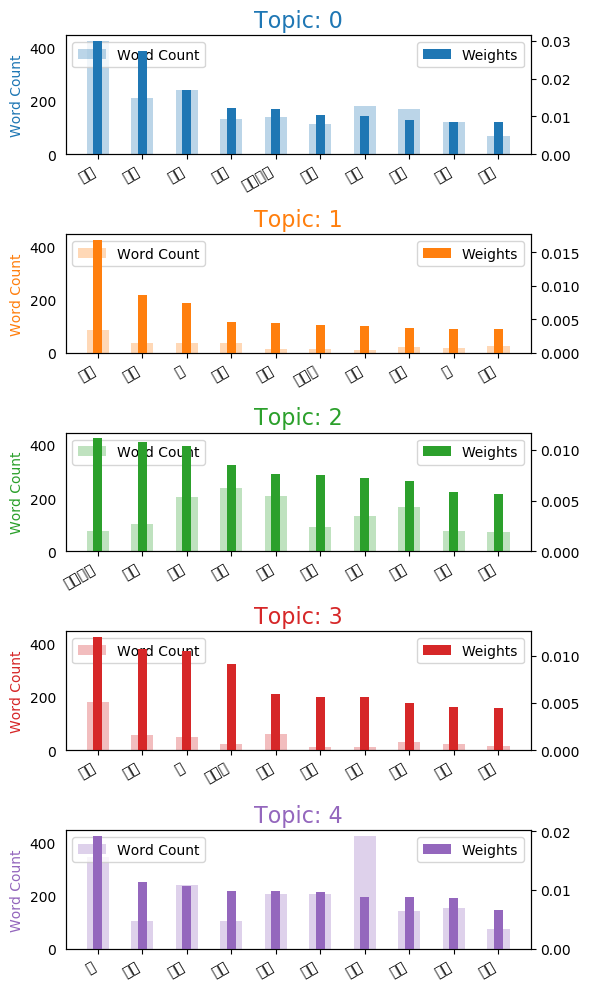

In [36]:
# For each decade, plot the graphs of Counts and importance of Topic 
# Keywords for all topics and save them in the visualization folder
graph_topic_keyword_count(lda_model_50, processed_50s, '50s')

In [ ]:
graph_topic_keyword_count(lda_model_70, processed_70s, '70s')

In [ ]:
graph_topic_keyword_count(lda_model_80, processed_80s, '80s')

In [ ]:
graph_topic_keyword_count(lda_model_90, processed_90s, '90s')

In [ ]:
graph_topic_keyword_count(lda_model_before_1979, processed_before_1979, 'pre market reform')

In [37]:
# construct the function that Visualize the topics interactively
def vis_interative(lda_model, corpus, dictionary, era):
    '''
    Interactively visualize an LDA topic model with two sets of related and 
    interactive graphs. The first one presents the prevalence of and relation
    between each topic. The second visualization uses a barchart where each 
    bar represents individual terms that are most useful for interpreting a 
    selected topic. Save an embedded visualization to a html file.

    input:
        lda_model: the lda model that identifies the topics
        corpus: the Term Document Frequency corpus used to build the mode
        dictionary: a dictionary containing word counts of each unique word
                    in the dataframe for each decade
        era: (str) the era of the dataframe (e.g. '70s')
    '''
    vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
   
    # Save an embedded visualization to file.
    # This will produce a self-contained HTML file. Internet access is 
    # still required for the D3 and LDAvis libraries.
    pyLDAvis.save_html(vis, './visualization/{}_topic_interaction_vis.html'.format(era))

In [40]:
# visualize the lda topic model for each decade interactively.
# save the 4 embedded visualizations into 4 html files
vis_interative(lda_model_50, corpus_50s, dic_50s, '50s')
vis_interative(lda_model_70, corpus_70s, dic_70s, '70s')
vis_interative(lda_model_80, corpus_80s, dic_80s, '80s')
vis_interative(lda_model_90, corpus_90s, dic_90s, '90s')
vis_interative(lda_model_before_1979, corpus_before_1979, dic_before_1979, 'before 1979')

/Users/ditong/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))
